In [45]:
import numpy as np 
import pandas as pd
import datetime
import time
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pyomo
import re
import math
import matplotlib.pyplot as plt
import os

In [46]:
## List all available building

main_dir = os.path.join(os.getcwd(), 'archetypes/')
all_files = os.listdir(main_dir)

# find type, age, climate, and number
type_ = []
age_ = []
climate_ = []
id_ = []
folder_ = []
for name in all_files:
    result = re.match(r'ep_(\w+)_age_(\d+)_climate_(\d+)_(\d+)$', name)
    if result:
        values = result.groups()
        type_.append(values[0])
        age_.append(values[1])
        climate_.append(values[2])
        id_.append(values[3])
        folder_.append(name)
buildings = pd.DataFrame({'type': type_, 'age': age_, 'climate': climate_, 'id': id_, 'folder': folder_})
print(buildings)

   type age climate    id                       folder
0   SFH   0       0  1241  ep_SFH_age_0_climate_0_1241
1   SFH   0       0   649   ep_SFH_age_0_climate_0_649
2   SFH   0       0   821   ep_SFH_age_0_climate_0_821
3   SFH   0       1   259   ep_SFH_age_0_climate_1_259
4   SFH   0       1   493   ep_SFH_age_0_climate_1_493
5   SFH   0       1   535   ep_SFH_age_0_climate_1_535
6   SFH   0       2  1325  ep_SFH_age_0_climate_2_1325
7   SFH   0       2  1691  ep_SFH_age_0_climate_2_1691
8   SFH   0       2  1972  ep_SFH_age_0_climate_2_1972
9   SFH   0       3  1081  ep_SFH_age_0_climate_3_1081
10  SFH   0       3  1123  ep_SFH_age_0_climate_3_1123
11  SFH   0       3   955   ep_SFH_age_0_climate_3_955
12  SFH   0       4  1072  ep_SFH_age_0_climate_4_1072
13  SFH   0       4  1688  ep_SFH_age_0_climate_4_1688
14  SFH   0       4  1709  ep_SFH_age_0_climate_4_1709
15  SFH   0       5   417   ep_SFH_age_0_climate_5_417
16  SFH   0       5   758   ep_SFH_age_0_climate_5_758
17  SFH   

In [47]:
## Define the building and its climate
current_id = buildings['id'][0]
current_climate = buildings['climate'][0]
current_folder = buildings['folder'][0]

list_files = os.listdir(os.path.join(main_dir, current_folder))
for file_ in list_files:
    result = re.search('weights', file_)
    if result:
        weight_file = file_
    result = re.search('bias', file_)
    if result:
        intercept_file = file_


In [48]:
def read_forecast_data(current_time, weather_df, 
                       history_hrs: int = 8, prediction_hrs: int = 24,
                       steps_per_hour: int = 4,
                       sol_terms: int = 9):
    
    history = history_hrs*steps_per_hour
    prediction = prediction_hrs*steps_per_hour

    current_index = np.argwhere(weather_df.index == current_time)[0][0]         
    idx_start = current_index - history
    idx_end = current_index + prediction
    data_block = weather_df.iloc[idx_start:idx_end, :]

    start_time = current_time - datetime.timedelta(hours=history_hrs)
    end_time = current_time + datetime.timedelta(hours=int(prediction/steps_per_hour))

    if start_time.year != current_time.year:
        start_time = datetime.datetime(year=current_time.year,
                                       month=start_time.month,
                                       day=start_time.day,
                                       hour=start_time.hour,
                                       minute=start_time.minute)
    if end_time.year != current_time.year:
        end_time = datetime.datetime(year=current_time.year,
                                     month=end_time.month,
                                     day=end_time.day,
                                     hour=end_time.hour,
                                     minute=end_time.minute)


    #  Temperature Forecast
    T_amb = np.array(data_block.iloc[:, data_block.columns.get_loc('T_amb')].copy())

    # Solar Forecast
    time_index = np.arange(start_time, end_time, datetime.timedelta(hours=1/steps_per_hour)).astype(datetime.datetime)
    solar_series = np.array(data_block.iloc[:, data_block.columns.get_loc('irrad')].copy())
    sol_mat = np.tile(solar_series.reshape(-1, 1), (1, sol_terms))
    enc_mat = np.zeros(shape=(len(time_index), sol_terms))
    for i in range(0, len(time_index)):
        hour = time_index[i].hour
        if 5 <= hour < 7: enc_mat[i, 0] = 1
        if 7 <= hour < 9: enc_mat[i, 1] = 1
        if 9 <= hour < 11: enc_mat[i, 2] = 1
        if 11 <= hour < 13: enc_mat[i, 3] = 1
        if 13 <= hour < 15: enc_mat[i, 4] = 1
        if 15 <= hour < 17: enc_mat[i, 5] = 1
        if 17 <= hour < 19: enc_mat[i, 6] = 1
        if 19 <= hour < 21: enc_mat[i, 7] = 1
        if 21 <= hour < 23: enc_mat[i, 8] = 1
    Solar = np.multiply(sol_mat, enc_mat)

    return T_amb, Solar

In [49]:
# open the weather .epw file
climate_class = current_climate
inputfile = open(os.path.join(os.getcwd(), f"archetypes/meteo/pop_weighted/current_CL_{climate_class}_weighted.epw"))
all_lines = inputfile.readlines() 
inputfile.close()

# parse the data
time_vec = []
temp_vec = []
irrd_vec = []

for count in range(len(all_lines)):
    if count <= 6:
        continue
    elements = all_lines[count].split(',')
    time_ = datetime.datetime(int(elements[0]), # year
                              int(elements[1]), # month
                              int(elements[2]), # day
                              int(elements[3]) % 24, # hour
                              0, # minute
                              0 # second
                              )
    ambient_temp_ = float(elements[6]) # ambient temperature in °C
    solar_irrd = float(elements[13]) # global solar radiation [W/m2]

    # append to the main lists
    time_vec.append(time_)
    temp_vec.append(ambient_temp_)
    irrd_vec.append(solar_irrd)

weather_df = pd.DataFrame({'time': time_vec, 'T_amb': temp_vec, 'irrad': irrd_vec})
weather_df.set_index('time', inplace = True)
weather_df = weather_df.resample('15min').interpolate() # hourly to 15 minute resolution

In [50]:
def initialize_history_data(start_initialization, length_initialization_hrs, target_temperature,
                            zones, armax_weights, armax_intercept, 
                            weather_df, history, param_names,
                            min_temp: float = 21.0, max_temp: float = 23.0,
                            lag_terms_list: list = [2,4,8,32],
                            steps_per_hour: int = 4,
                            sol_terms: int = 9, plot_: bool = False):
    
    # parameters definition
    length_initialization = length_initialization_hrs * steps_per_hour
    # define upper and lower bounds
    T_min, T_max = min_temp * np.ones((zones, length_initialization+1)), max_temp * np.ones((zones, length_initialization+1))

    # lags of the ARMAX
    dynamics_lags_list = lag_terms_list.copy()
    dynamics_lags_list.insert(0, 1)
    feat_length = int(len(param_names) / len(dynamics_lags_list))

    pos_T1 = param_names.get_loc('T1')
    pos_u1 = param_names.get_loc('u1')
    pos_T_amb = param_names.get_loc('T_amb')
    pos_s1 = param_names.get_loc('s1')
    pos_s9 = param_names.get_loc('s9')

    # initialize to unrealistic values
    history_T_zones = target_temperature * np.ones((history+1, zones)) # initial temperature guess
    history_b_zones = np.zeros((history+1, zones))
    
    # Run an optimization that initializes the historical data - objective = keep at the target temperature
    # start_weather = start_initialization - datetime.timedelta(hours = history / steps_per_hour)
    # stop_weather = start_initialization + datetime.timedelta(hours = length_initialization_hrs)
    # weather = weather_df.loc[(weather_df.index >= start_weather) & (weather_df.index < stop_weather), :].copy()
    T_amb, Solar = read_forecast_data(start_initialization, weather_df, history_hrs = int(history / steps_per_hour), 
                                      prediction_hrs = length_initialization_hrs, steps_per_hour = steps_per_hour,
                                      sol_terms = sol_terms)

    # Initialize optimization model and solver
    optimizer_model = pyo.ConcreteModel()
    solver_name = 'gurobi'  # 'cplex'
    optimizer_solver = SolverFactory(solver_name)  # SolverFactory('cplex')

    start_time = time.time()

    # Optimization Ranges
    zone_range = range(zones)
    input_range = np.arange(-history, length_initialization, dtype=int)
    state_range = np.arange(-history, length_initialization + 1, dtype=int)
    slack_range = np.arange(0, length_initialization+1, dtype=int)

    # Optimization Variables
    optimizer_model.b = pyo.Var(input_range, zone_range, bounds=(0, 1), domain=pyo.Reals)  # domain=pe.NonNegativeReals
    optimizer_model.x = pyo.Var(state_range, zone_range, domain=pyo.Reals)
    optimizer_model.a = pyo.Var(input_range, domain=pyo.Reals)
    optimizer_model.s = pyo.Var(input_range, range(sol_terms), domain=pyo.Reals)
    optimizer_model.slack = pyo.Var(slack_range, zone_range, domain=pyo.NonNegativeReals)
            
    # Equality constraints "Room dynamics model"
    optimizer_model.Dynamics = pyo.ConstraintList()
    for r in range(zones):
        for k in range(1, length_initialization + 1):
            optimizer_model.Dynamics.add(optimizer_model.x[k, r] ==
                                        sum(
                                            sum(armax_weights[i * feat_length + pos_T1 + rr, r] *
                                                optimizer_model.x[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            sum(armax_weights[i * feat_length + pos_u1 + rr, r] *
                                                optimizer_model.b[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            (armax_weights[i * feat_length + pos_T_amb, r] *
                                            optimizer_model.a[k - dynamics_lags_list[i]]) +
                                            sum(armax_weights[i * feat_length + pos_s1 + ss, r] *
                                                optimizer_model.s[k - dynamics_lags_list[i], ss]
                                                for ss in range(sol_terms))
                                            for i in range(len(dynamics_lags_list))) 
                                            + armax_intercept[r,0]
                                        )
            
    # Assign ambient temperature to variables
    optimizer_model.Ambient = pyo.ConstraintList()
    for k in range(-history, length_initialization):
        optimizer_model.Ambient.add(optimizer_model.a[k] == T_amb[k + history])

    # Assign solar irradiation to variables
    optimizer_model.Solar = pyo.ConstraintList()
    for k in range(-history, length_initialization):
        for i in range(sol_terms):
            optimizer_model.Solar.add(optimizer_model.s[k, i] == Solar[k + history, i])

    # Inequality constraints, Temperature constraints for each time step
    optimizer_model.T_bounds = pyo.ConstraintList()
    for r in range(zones):
        for k in range(0, length_initialization+1): 
            optimizer_model.T_bounds.add(optimizer_model.x[k, r] >= T_min[r, k] - optimizer_model.slack[k, r])
            optimizer_model.T_bounds.add(optimizer_model.x[k, r] <= T_max[r, k] + optimizer_model.slack[k, r])

    # Set input and state variables equal to past measurements
    optimizer_model.T_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 1):
            optimizer_model.T_past.add(optimizer_model.x[k, r] == history_T_zones[k + history, r])

    optimizer_model.b_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 0):
            optimizer_model.b_past.add(optimizer_model.b[k, r] == history_b_zones[k + history, r])


    # Define cost function "quadratic in control input and linear in slack variable"
    # b is the input power in this case
    optimizer_model.OBJ = pyo.Objective(expr=sum(
                sum(optimizer_model.slack[k, rr] for k in range(1, length_initialization+1)) +
                sum((optimizer_model.x[k, rr] - target_temperature)**2 for k in range(0, length_initialization+1))  # exponentially decaying
                for rr in range(zones)), sense=pyomo.core.minimize
    )

    # Solve Optimization Problem
    start_time = time.time()
    print('Start solving Optimization Problem for initialization...')
    optimizer_solver.solve(optimizer_model, tee=False)
    print(f'Finish solving Optimization Problem for initialization. Used {time.time() - start_time} seconds.')

    # Append optimized values to history
    # Result Arrays "Store solution in numpy array"
    T_z_pred = np.zeros(shape=(length_initialization, zones))
    b_pred = np.zeros(shape=(length_initialization, zones))
    for r in range(zones):
        for k in range(0, length_initialization):
            T_z_pred[k, r] = optimizer_model.x[k + 1, r].value
            b_pred[k, r] = optimizer_model.b[k, r].value

    if plot_: # visualize the results
        fig, axes = plt.subplots(2,1)
        for r in range(zones):
            axes[0].plot(T_z_pred[:,r])
            axes[1].plot(b_pred[:,r])
        axes[0].legend(zone_range)
        fig.show()

    return T_z_pred, b_pred




In [51]:
weights_path = os.path.join(main_dir, current_folder, weight_file)
intercepts_path = os.path.join(main_dir, current_folder, intercept_file)

lag_hours_list = np.array([6 / 12, 1, 2, 8])
steps_per_hour =  4 
history_hrs = 8
prediction_hrs = 24
sol_terms = 9
min_temp = 20 # °C
max_temp = 22 # °C

lag_terms_list = list((lag_hours_list *steps_per_hour).astype(int))
param_names = pd.read_csv(filepath_or_buffer=weights_path, index_col=0).columns
history = history_hrs*steps_per_hour
prediction = prediction_hrs*steps_per_hour
armax_params = np.transpose(np.array(pd.read_csv(filepath_or_buffer=weights_path, index_col=0)))
armax_intercept = np.array(pd.read_csv(filepath_or_buffer=intercepts_path, index_col=0))

# find the number of zones
all_columns = pd.read_csv(filepath_or_buffer=weights_path).columns
count = 0
for name in all_columns:
    result = re.match(r'T([\d])$', name)
    if result:
        count += 1
zones = count

# define upper and lower bounds
T_min, T_max = min_temp * np.ones((zones, prediction+1)), max_temp * np.ones((zones, prediction+1))

# lags of the ARMAX
dynamics_lags_list = lag_terms_list.copy()
dynamics_lags_list.insert(0, 1)
feat_length = int(len(param_names) / len(dynamics_lags_list))

# weights of the slack in the objective function
alpha_factor = (-1) * (1/prediction) * math.log(0.01)
# position of the first temperature in the list
pos_T1 = param_names.get_loc('T1')
pos_u1 = param_names.get_loc('u1')
pos_T_amb = param_names.get_loc('T_amb')
pos_s1 = param_names.get_loc('s1')

In [52]:
## Baseline Computation ##

def baseline(T_amb, Solar, T_min, T_max, target_temprature,
                history_T_zones, history_b_zones, 
                history, prediction, zones, 
                feat_length, pos_T1, pos_u1, pos_T_amb, pos_s1, dynamics_lags_list,
                armax_params, armax_intercept,
                solver_name: str = 'gurobi',
                plot_: bool = True):

    # Initialize optimization model and solver
    optimizer_model = pyo.ConcreteModel()
    optimizer_solver = SolverFactory(solver_name)  # SolverFactory('cplex')

    start_time = time.time()

    # Optimization Ranges
    zone_range = range(zones)
    input_range = np.arange(-history, prediction, dtype=int)
    state_range = np.arange(-history, prediction + 1, dtype=int)
    slack_range = np.arange(0, prediction + 1, dtype=int)

    # Optimization Variables
    optimizer_model.b = pyo.Var(input_range, zone_range, bounds=(0, 1), domain=pyo.Reals)  # domain=pe.NonNegativeReals
    optimizer_model.x = pyo.Var(state_range, zone_range, domain=pyo.Reals)
    optimizer_model.a = pyo.Var(input_range, domain=pyo.Reals)
    optimizer_model.s = pyo.Var(input_range, range(sol_terms), domain=pyo.Reals)
    optimizer_model.slack = pyo.Var(slack_range, zone_range, domain=pyo.NonNegativeReals)
            
    # Equality constraints "Room dynamics model"
    optimizer_model.Dynamics = pyo.ConstraintList()
    for r in range(zones):
        for k in range(1, prediction + 1):
            optimizer_model.Dynamics.add(optimizer_model.x[k, r] ==
                                        sum(
                                            sum(armax_params[i * feat_length + pos_T1 + rr, r] *
                                                optimizer_model.x[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            sum(armax_params[i * feat_length + pos_u1 + rr, r] *
                                                optimizer_model.b[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            (armax_params[i * feat_length + pos_T_amb, r] *
                                            optimizer_model.a[k - dynamics_lags_list[i]]) +
                                            sum(armax_params[i * feat_length + pos_s1 + ss, r] *
                                                optimizer_model.s[k - dynamics_lags_list[i], ss]
                                                for ss in range(sol_terms))
                                            for i in range(len(dynamics_lags_list))) 
                                            + armax_intercept[r,0]
                                        )
            
    # Assign ambient temperature to variables
    optimizer_model.Ambient = pyo.ConstraintList()
    for k in range(-history, prediction):
        optimizer_model.Ambient.add(optimizer_model.a[k] == T_amb[k + history])

    # Assign solar irradiation to variables
    optimizer_model.Solar = pyo.ConstraintList()
    for k in range(-history, prediction):
        for i in range(sol_terms):
            optimizer_model.Solar.add(optimizer_model.s[k, i] == Solar[k + history, i])

    # Inequality constraints, Temperature constraints for each time step
    optimizer_model.T_bounds = pyo.ConstraintList()
    for r in range(zones):
        for k in range(0, prediction+1): 
            optimizer_model.T_bounds.add(optimizer_model.x[k, r] >= T_min[r, k] - optimizer_model.slack[k, r])
            optimizer_model.T_bounds.add(optimizer_model.x[k, r] <= T_max[r, k] + optimizer_model.slack[k, r])

    # Set input and state variables equal to past measurements
    optimizer_model.T_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 1):
            optimizer_model.T_past.add(optimizer_model.x[k, r] == history_T_zones[k + history, r])

    optimizer_model.b_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 0):
            optimizer_model.b_past.add(optimizer_model.b[k, r] == history_b_zones[k + history, r])


    # Define cost function "quadratic in control input and linear in slack variable"
    # b is the input power in this case
    optimizer_model.OBJ = pyo.Objective(expr=sum(
                sum(optimizer_model.slack[k, rr] for k in range(1, prediction+1)) +
                sum((optimizer_model.x[k, rr] - target_temprature)**2 for k in range(0, prediction+1))  # exponentially decaying
                for rr in range(zones)), sense=pyomo.core.minimize
    )

    # Solve Optimization Problem
    start_time = time.time()
    print('Start solving Optimization Problem for baseline...')
    optimizer_solver.solve(optimizer_model, tee=False)
    print(f'Finish solving Optimization Problem for baseline. Used {time.time() - start_time} seconds.')

    # Append optimized values to history
    # Result Arrays "Store solution in numpy array"
    T_z_pred = np.zeros(shape=(prediction, zones))
    b_pred = np.zeros(shape=(prediction, zones))
    for r in range(zones):
        for k in range(0, prediction):
            T_z_pred[k, r] = optimizer_model.x[k + 1, r].value
            b_pred[k, r] = optimizer_model.b[k, r].value

    if plot_:
        fig, axes = plt.subplots(2,1,sharex=True)
        for r in range(zones):
            axes[0].plot(T_z_pred[:,r])
            axes[1].plot(b_pred[:,r])
        axes[0].legend(zone_range)
        fig.show()

    updated_history_T_zones = np.concatenate((history_T_zones[1:, :], T_z_pred), axis=0)
    updated_history_b_zones = np.concatenate((history_b_zones, b_pred), axis=0)
    
    return updated_history_T_zones, updated_history_b_zones


In [53]:
## Upper Bound Computation ##

def upper_bound(T_amb, Solar, T_min, T_max,
                history_T_zones, history_b_zones, 
                history, prediction, zones, 
                feat_length, pos_T1, pos_u1, pos_T_amb, pos_s1, dynamics_lags_list,
                armax_params, armax_intercept,
                alpha_factor,
                solver_name: str = 'gurobi',
                plot_: bool = True):

    # Initialize optimization model and solver
    optimizer_model_ub = pyo.ConcreteModel()
    optimizer_solver = SolverFactory(solver_name)  # SolverFactory('cplex')

    start_time = time.time()

    # Optimization Ranges
    zone_range = range(zones)
    input_range = np.arange(-history, prediction, dtype=int)
    state_range = np.arange(-history, prediction + 1, dtype=int)
    slack_range = np.arange(0, prediction + 1, dtype=int)

    # Optimization Variables
    optimizer_model_ub.b = pyo.Var(input_range, zone_range, bounds=(0, 1), domain=pyo.Reals)  # domain=pe.NonNegativeReals
    optimizer_model_ub.x = pyo.Var(state_range, zone_range, domain=pyo.Reals)
    optimizer_model_ub.a = pyo.Var(input_range, domain=pyo.Reals)
    optimizer_model_ub.s = pyo.Var(input_range, range(sol_terms), domain=pyo.Reals)
    optimizer_model_ub.slack = pyo.Var(slack_range, zone_range, domain=pyo.NonNegativeReals)
            
    # Equality constraints "Room dynamics model"
    optimizer_model_ub.Dynamics = pyo.ConstraintList()
    for r in range(zones):
        for k in range(1, prediction + 1):
            optimizer_model_ub.Dynamics.add(optimizer_model_ub.x[k, r] ==
                                        sum(
                                            sum(armax_params[i * feat_length + pos_T1 + rr, r] *
                                                optimizer_model_ub.x[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            sum(armax_params[i * feat_length + pos_u1 + rr, r] *
                                                optimizer_model_ub.b[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            (armax_params[i * feat_length + pos_T_amb, r] *
                                            optimizer_model_ub.a[k - dynamics_lags_list[i]]) +
                                            sum(armax_params[i * feat_length + pos_s1 + ss, r] *
                                                optimizer_model_ub.s[k - dynamics_lags_list[i], ss]
                                                for ss in range(sol_terms))
                                            for i in range(len(dynamics_lags_list))) 
                                            + armax_intercept[r,0]
                                        )
            
    # Assign ambient temperature to variables
    optimizer_model_ub.Ambient = pyo.ConstraintList()
    for k in range(-history, prediction):
        optimizer_model_ub.Ambient.add(optimizer_model_ub.a[k] == T_amb[k + history])

    # Assign solar irradiation to variables
    optimizer_model_ub.Solar = pyo.ConstraintList()
    for k in range(-history, prediction):
        for i in range(sol_terms):
            optimizer_model_ub.Solar.add(optimizer_model_ub.s[k, i] == Solar[k + history, i])

    # Inequality constraints, Temperature constraints for each time step
    optimizer_model_ub.T_bounds = pyo.ConstraintList()
    for r in range(zones):
        for k in range(0, prediction+1): 
            optimizer_model_ub.T_bounds.add(optimizer_model_ub.x[k, r] >= T_min[r, k] - optimizer_model_ub.slack[k, r])
            optimizer_model_ub.T_bounds.add(optimizer_model_ub.x[k, r] <= T_max[r, k] + optimizer_model_ub.slack[k, r])

    # Set input and state variables equal to past measurements
    optimizer_model_ub.T_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 1):
            optimizer_model_ub.T_past.add(optimizer_model_ub.x[k, r] == history_T_zones[k + history, r])

    optimizer_model_ub.b_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 0):
            optimizer_model_ub.b_past.add(optimizer_model_ub.b[k, r] == history_b_zones[k + history, r])


    # Define cost function "quadratic in control input and linear in slack variable"
    # b is the input power in this case
    optimizer_model_ub.OBJ = pyo.Objective(expr=sum(
                sum(optimizer_model_ub.slack[k, rr] for k in range(1, prediction+1)) +
                sum((optimizer_model_ub.b[k, rr])*(-1)*math.exp((-1) * alpha_factor * k) for k in range(0, prediction))  # exponentially decaying
                for rr in range(zones)), sense=pyomo.core.minimize
    )

    # Solve Optimization Problem
    start_time = time.time()
    print('Start solving Optimization Problem for upper bound...')
    optimizer_solver.solve(optimizer_model_ub, tee=False)
    print(f'Finish solving Optimization Problem for upper bound. Used {time.time() - start_time} seconds.')

    # Append optimized values to history
    # Result Arrays "Store solution in numpy array"
    T_z_pred = np.zeros(shape=(prediction, zones))
    b_pred = np.zeros(shape=(prediction, zones))
    for r in range(zones):
        for k in range(0, prediction):
            T_z_pred[k, r] = optimizer_model_ub.x[k + 1, r].value
            b_pred[k, r] = optimizer_model_ub.b[k, r].value

    if plot_:
        fig, axes = plt.subplots(2,1,sharex=True)
        for r in range(zones):
            axes[0].plot(T_z_pred[:,r])
            axes[1].plot(b_pred[:,r])
        axes[0].legend(zone_range)
        fig.show()

    return T_z_pred, b_pred


In [54]:
## Lower Bound computation ##

def lower_bound(T_amb, Solar, T_min, T_max,
                history_T_zones, history_b_zones, 
                history, prediction, zones, 
                feat_length, pos_T1, pos_u1, pos_T_amb, pos_s1, dynamics_lags_list,
                armax_params, armax_intercept,
                alpha_factor,
                solver_name: str = 'gurobi',
                plot_: bool = True):

    # Initialize optimization model and solver
    optimizer_model_lb = pyo.ConcreteModel()
    optimizer_solver = SolverFactory(solver_name)  # SolverFactory('cplex')

    start_time = time.time()

    # Optimization Ranges
    zone_range = range(zones)
    input_range = np.arange(-history, prediction, dtype=int)
    state_range = np.arange(-history, prediction + 1, dtype=int)
    slack_range = np.arange(0, prediction + 1, dtype=int)

    # Optimization Variables
    optimizer_model_lb.b = pyo.Var(input_range, zone_range, bounds=(0, 1), domain=pyo.Reals)  # domain=pe.NonNegativeReals

    optimizer_model_lb.x = pyo.Var(state_range, zone_range, domain=pyo.Reals)
    optimizer_model_lb.a = pyo.Var(input_range, domain=pyo.Reals)
    optimizer_model_lb.s = pyo.Var(input_range, range(sol_terms), domain=pyo.Reals)
    optimizer_model_lb.slack = pyo.Var(slack_range, zone_range, domain=pyo.NonNegativeReals)
            
    # Equality constraints "Room dynamics model"
    optimizer_model_lb.Dynamics = pyo.ConstraintList()
    for r in range(zones):
        for k in range(1, prediction + 1):
            optimizer_model_lb.Dynamics.add(optimizer_model_lb.x[k, r] ==
                                        sum(
                                            sum(armax_params[i * feat_length + pos_T1 + rr, r] *
                                                optimizer_model_lb.x[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            sum(armax_params[i * feat_length + pos_u1 + rr, r] *
                                                optimizer_model_lb.b[k - dynamics_lags_list[i], rr]
                                                for rr in range(zones)) +
                                            (armax_params[i * feat_length + pos_T_amb, r] *
                                            optimizer_model_lb.a[k - dynamics_lags_list[i]]) +
                                            sum(armax_params[i * feat_length + pos_s1 + ss, r] *
                                                optimizer_model_lb.s[k - dynamics_lags_list[i], ss]
                                                for ss in range(sol_terms))
                                            for i in range(len(dynamics_lags_list))) 
                                            + armax_intercept[r,0]
                                        )
            
    # Assign ambient temperature to variables
    optimizer_model_lb.Ambient = pyo.ConstraintList()
    for k in range(-history, prediction):
        optimizer_model_lb.Ambient.add(optimizer_model_lb.a[k] == T_amb[k + history])

    # Assign solar irradiation to variables
    optimizer_model_lb.Solar = pyo.ConstraintList()
    for k in range(-history, prediction):
        for i in range(sol_terms):
            optimizer_model_lb.Solar.add(optimizer_model_lb.s[k, i] == Solar[k + history, i])

    # Inequality constraints, Temperature constraints for each time step
    optimizer_model_lb.T_bounds = pyo.ConstraintList()
    for r in range(zones):
        for k in range(0, prediction+1): 
            optimizer_model_lb.T_bounds.add(optimizer_model_lb.x[k, r] >= T_min[r, k] - optimizer_model_lb.slack[k, r])
            optimizer_model_lb.T_bounds.add(optimizer_model_lb.x[k, r] <= T_max[r, k] + optimizer_model_lb.slack[k, r])

    # Set input and state variables equal to past measurements
    optimizer_model_lb.T_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 1):
            optimizer_model_lb.T_past.add(optimizer_model_lb.x[k, r] == history_T_zones[k + history, r])

    optimizer_model_lb.b_past = pyo.ConstraintList()
    for r in range(zones):
        for k in range(-history, 0):
            optimizer_model_lb.b_past.add(optimizer_model_lb.b[k, r] == history_b_zones[k + history, r])


    # Define cost function "quadratic in control input and linear in slack variable"
    # b is the input power in this case
    optimizer_model_lb.OBJ = pyo.Objective(expr=sum(
                sum(optimizer_model_lb.slack[k, rr] for k in range(1, prediction+1)) +
                sum((optimizer_model_lb.b[k, rr])*math.exp((-1) * alpha_factor * k) for k in range(0, prediction))  # exponentially decaying
                for rr in range(zones)), sense=pyomo.core.minimize
    )

    # Solve Optimization Problem
    start_time = time.time()
    print('Start solving Optimization Problem for lower bound...')
    optimizer_solver.solve(optimizer_model_lb, tee=False)
    print(f'Finish solving Optimization Problem for lower bound. Used {time.time() - start_time} seconds.')

    # Append optimized values to history
    # Result Arrays "Store solution in numpy array"
    T_z_pred = np.zeros(shape=(prediction, zones))
    b_pred = np.zeros(shape=(prediction, zones))
    for r in range(zones):
        for k in range(0, prediction):
            T_z_pred[k, r] = optimizer_model_lb.x[k + 1, r].value
            b_pred[k, r] = optimizer_model_lb.b[k, r].value

    if plot_:
        fig, axes = plt.subplots(2,1)
        for r in range(zones):
            axes[0].plot(T_z_pred[:,r])
            axes[1].plot(b_pred[:,r])
        axes[0].legend(zone_range)
        fig.show()

    return T_z_pred, b_pred

Start solving Optimization Problem for initialization...
Finish solving Optimization Problem for initialization. Used 0.5560047626495361 seconds.


C:\Users\roju\AppData\Local\Temp\ipykernel_8044\966759617.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


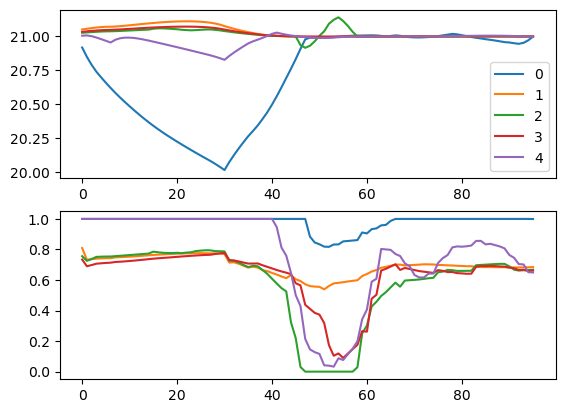

In [55]:
## Initialization
history_T_zones, history_b_zones = initialize_history_data(start_initialization=datetime.datetime(2020,1,4,0,0,0), 
                                                           length_initialization_hrs = 24, target_temperature = 21, 
                                                           zones = zones, 
                                                           armax_weights = armax_params, armax_intercept = armax_intercept, 
                                                           weather_df = weather_df, 
                                                           history = history, param_names = param_names,
                                                           min_temp = min_temp, max_temp = max_temp,
                                                           lag_terms_list = lag_terms_list,
                                                           steps_per_hour = steps_per_hour,
                                                           sol_terms = sol_terms, 
                                                           plot_ = True)

In [56]:
current_time = datetime.datetime(2020,1,8,0,0,0)
stop_simulation = datetime.datetime(2020,1,9,0,0,0)
simulation_steps_hrs = 6

while current_time <= stop_simulation:

    # define historical weather conditions 
    T_amb, Solar = read_forecast_data(current_time, weather_df)

    # Calculate the energy bounds
    T_ub, b_ub = upper_bound(T_amb = T_amb, Solar = Solar, T_min = T_min, T_max = T_max,
                            history_T_zones = history_T_zones, history_b_zones = history_b_zones, 
                            history = history, prediction = prediction, zones = zones, 
                            feat_length = feat_length, pos_T1 = pos_T1, pos_u1 = pos_u1, 
                            pos_T_amb = pos_T_amb, pos_s1 = pos_s1, dynamics_lags_list = dynamics_lags_list,
                            armax_params = armax_params, armax_intercept = armax_intercept,
                            alpha_factor = alpha_factor, plot_ = False)
    T_lb, b_lb = lower_bound(T_amb = T_amb, Solar = Solar, T_min = T_min, T_max = T_max,
                            history_T_zones = history_T_zones, history_b_zones = history_b_zones, 
                            history = history, prediction = prediction, zones = zones, 
                            feat_length = feat_length, pos_T1 = pos_T1, pos_u1 = pos_u1, 
                            pos_T_amb = pos_T_amb, pos_s1 = pos_s1, dynamics_lags_list = dynamics_lags_list,
                            armax_params = armax_params, armax_intercept = armax_intercept,
                            alpha_factor = alpha_factor, plot_ = False)
    
    
    # Run an optimization to keep temperature constant at target temperature (replicate a controller, 
    # used to generate historical data - necessary to run the ARMAX)
    history_T_zones, history_b_zones = baseline(T_amb = T_amb, Solar = Solar, T_min = T_min, T_max = T_max,
                                                target_temprature = 21,
                                                history_T_zones = history_T_zones, history_b_zones = history_b_zones, 
                                                history = history, prediction = prediction, zones = zones, 
                                                feat_length = feat_length, pos_T1 = pos_T1, pos_u1 = pos_u1, 
                                                pos_T_amb = pos_T_amb, pos_s1 = pos_s1, dynamics_lags_list = dynamics_lags_list,
                                                armax_params = armax_params, armax_intercept = armax_intercept, plot_ = False)
    
    print(f"{current_time} finished succesfully.")
    current_time += datetime.timedelta(hours = simulation_steps_hrs)


Start solving Optimization Problem for upper bound...
Finish solving Optimization Problem for upper bound. Used 0.5586442947387695 seconds.
Start solving Optimization Problem for lower bound...
Finish solving Optimization Problem for lower bound. Used 0.6588220596313477 seconds.
Start solving Optimization Problem for baseline...
Finish solving Optimization Problem for baseline. Used 0.5406348705291748 seconds.
2020-01-08 00:00:00 finished succesfully.
Start solving Optimization Problem for upper bound...
Finish solving Optimization Problem for upper bound. Used 0.31793713569641113 seconds.
Start solving Optimization Problem for lower bound...
Finish solving Optimization Problem for lower bound. Used 0.3761730194091797 seconds.
Start solving Optimization Problem for baseline...
Finish solving Optimization Problem for baseline. Used 0.3873450756072998 seconds.
2020-01-08 06:00:00 finished succesfully.
Start solving Optimization Problem for upper bound...
Finish solving Optimization Probl

C:\Users\roju\AppData\Local\Temp\ipykernel_8044\2780050909.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


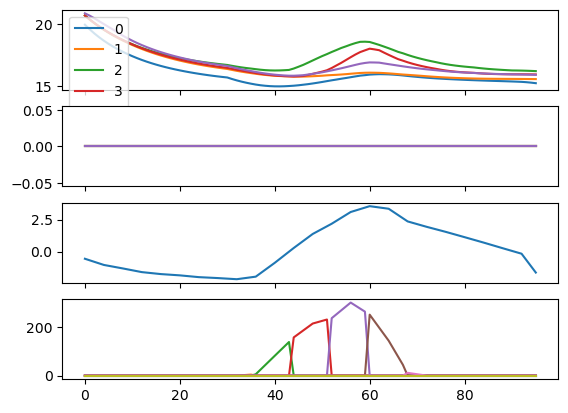

In [61]:
# Test the ARMAX

## What if we have the ambient and solar gains but no power inputs ##

# define historical weather conditions 
current_time = datetime.datetime(2020,1,8,0,0,0)
T_amb, Solar = read_forecast_data(current_time, weather_df)

temperature = np.zeros((history+prediction+1, zones))
power = np.zeros((history+prediction, zones))
# Initialize
for r in range(zones):
    for k in range(history+1):
        temperature[k,r] = history_T_zones[k, r]
for r in range(zones):
    for k in range(history):
        power[k,r]= history_b_zones[k, r]

for k in range(history + 1, history + prediction + 1):
    for r in range(zones):
        temperature[k, r] = np.sum([np.sum([armax_params[i * feat_length + pos_T1 + rr, r] * temperature[k - dynamics_lags_list[i], rr] for rr in range(zones)]) 
                                + np.sum([armax_params[i * feat_length + pos_u1 + rr, r] * power[k - dynamics_lags_list[i], rr] for rr in range(zones)]) 
                                + (armax_params[i * feat_length + pos_T_amb, r] * T_amb[k - dynamics_lags_list[i]]) 
                                + np.sum([armax_params[i * feat_length + pos_s1 + ss, r] * Solar[k - dynamics_lags_list[i], ss] for ss in range(sol_terms)])
                                    for i in range(len(dynamics_lags_list))]) + armax_intercept[r,0]
            
fig, axes = plt.subplots(4,1, sharex=True)
for r in range(zones):
    axes[0].plot(temperature[history+1:,r])
    axes[1].plot(power[history:,r])
axes[0].legend(range(zones))
axes[2].plot(T_amb[history:])
for s in range(sol_terms):
    axes[3].plot(Solar[history:,s])
fig.show()


C:\Users\roju\AppData\Local\Temp\ipykernel_8044\2736652853.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


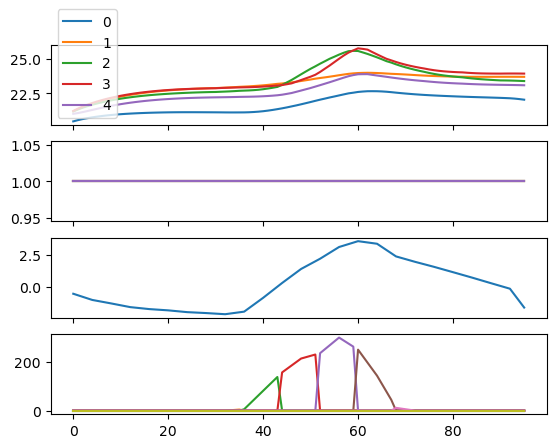

In [62]:
# Test the ARMAX

## What if we have the ambient and solar gains and full power inputs ##

# define historical weather conditions 
current_time = datetime.datetime(2020,1,8,0,0,0)
T_amb, Solar = read_forecast_data(current_time, weather_df)

temperature = np.zeros((history+prediction+1, zones))
power = np.zeros((history+prediction, zones))
# Initialize
for r in range(zones):
    for k in range(history+1):
        temperature[k,r] = history_T_zones[k, r]
for r in range(zones):
    for k in range(history):
        power[k,r]= history_b_zones[k, r]
power[history:,:] = 1

for k in range(history + 1, history + prediction + 1):
    for r in range(zones):
        temperature[k, r] = np.sum([np.sum([armax_params[i * feat_length + pos_T1 + rr, r] * temperature[k - dynamics_lags_list[i], rr] for rr in range(zones)]) 
                                + np.sum([armax_params[i * feat_length + pos_u1 + rr, r] * power[k - dynamics_lags_list[i], rr] for rr in range(zones)]) 
                                + (armax_params[i * feat_length + pos_T_amb, r] * T_amb[k - dynamics_lags_list[i]]) 
                                + np.sum([armax_params[i * feat_length + pos_s1 + ss, r] * Solar[k - dynamics_lags_list[i], ss] for ss in range(sol_terms)])
                                    for i in range(len(dynamics_lags_list))]) + armax_intercept[r,0]
            
fig, axes = plt.subplots(4,1, sharex=True)
for r in range(zones):
    axes[0].plot(temperature[history+1:,r])
    axes[1].plot(power[history:,r])
axes[0].legend(range(zones))
axes[2].plot(T_amb[history:])
for s in range(sol_terms):
    axes[3].plot(Solar[history:,s])
fig.show()


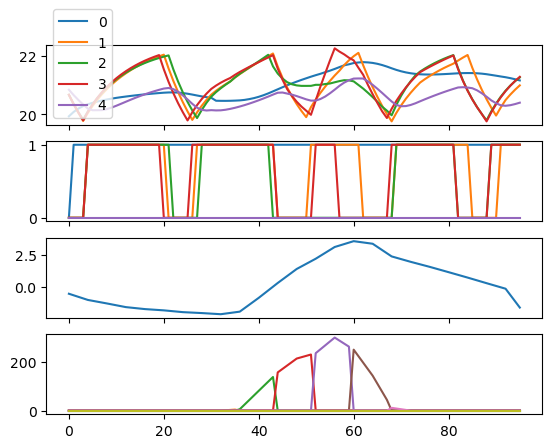

In [64]:
# Test the ARMAX

## Basic rule-based controller per room ##

# define historical weather conditions 
current_time = datetime.datetime(2020,1,8,0,0,0)
T_amb, Solar = read_forecast_data(current_time, weather_df)

temperature = np.zeros((history+prediction+1, zones))
power = np.zeros((history+prediction, zones))
# Initialize
for r in range(zones):
    for k in range(history+1):
        temperature[k,r] = history_T_zones[k, r]
for r in range(zones):
    for k in range(history):
        power[k,r]= history_b_zones[k, r]

for k in range(history + 1, history + prediction + 1):
    for r in range(zones):
        temperature[k, r] = np.sum([np.sum([armax_params[i * feat_length + pos_T1 + rr, r] * temperature[k - dynamics_lags_list[i], rr] for rr in range(zones)]) 
                                + np.sum([armax_params[i * feat_length + pos_u1 + rr, r] * power[k - dynamics_lags_list[i], rr] for rr in range(zones)]) 
                                + (armax_params[i * feat_length + pos_T_amb, r] * T_amb[k - dynamics_lags_list[i]]) 
                                + np.sum([armax_params[i * feat_length + pos_s1 + ss, r] * Solar[k - dynamics_lags_list[i], ss] for ss in range(sol_terms)])
                                    for i in range(len(dynamics_lags_list))]) + armax_intercept[r,0]

        if k < history + prediction: # ignore last timestep
            if temperature[k, r] < 20:
            # if the temperature is below the minimum, we add power
                power[k, r] = 1
            elif temperature[k, r] > 22:
            # if the temperature is above the maximum, we remove power
                power[k, r] = 0
            else:
            # if the temperature is within the bounds, we keep the power constant
                power[k, r] = power[k - 1, r]
            
fig, axes = plt.subplots(4,1, sharex=True)
for r in range(zones):
    axes[0].plot(temperature[history+1:,r])
    axes[1].plot(power[history:,r])
axes[0].legend(range(zones))
axes[2].plot(T_amb[history:])
for s in range(sol_terms):
    axes[3].plot(Solar[history:,s])
